In [1]:
# Loads gaze-related metrics for each trial and participant and performs statistical analysis for the whole study 

In [2]:
import re
import matplotlib.pyplot as plt
from enum import Enum
import os
import statistics
import numpy as np
import get_tcm as tcm
import helpers as hl

import csv
import pandas as pd

import pandas as pd
import statsmodels.api as sm
from statsmodels.formula.api import ols
import pingouin as pg

from statsmodels.stats.anova import AnovaRM

from scipy.stats import sem, t, ttest_rel, shapiro, wilcoxon, mannwhitneyu

import seaborn as sns

In [3]:
# data_dir="Z:/builds/aplause-mr/UNITY_APP/aplause-mr-20240707-studystate-v1/gazeAnalysisv2"
data_dir="C:/Users/gary4/Documents/Work/BUW/Research/MR4/gazeAnalysisv2"

file_path = data_dir + "/gaze_classification_analysis_results.csv"

df = pd.read_csv(file_path)
df

,participant_id,trial,group,condition,audio_condition,avatar_condition,gaze_local_pc,gaze_remote_adjacent_pc,gaze_remote_opposite_pc,gaze_others_pc,...,glance_remote_opposite_per_min,mutual_gaze_local_pc,mutual_gaze_local_mean_duration,mutual_gaze_local_per_min,mutual_gaze_remote_opp_pc,mutual_gaze_remote_opp_mean_duration,mutual_gaze_remote_opp_per_min,mutual_gaze_remote_adj_pc,mutual_gaze_remote_adj_mean_duration,mutual_gaze_remote_adj_per_min
0,0,0,0,DIOTIC_VOLUMETRIC,DIOTIC,VOLUMETRIC,17.737321,11.651495,53.602081,82.990897,...,13.732120,2.470741,1.187500,1.248375,33.914174,1.358333,14.980494,3.485046,0.744444,2.808843
1,1,0,0,DIOTIC_VOLUMETRIC,DIOTIC,VOLUMETRIC,5.253576,21.430429,37.425228,64.109233,...,10.923277,2.470741,1.187500,1.248375,10.403121,0.655738,9.518856,2.418726,0.715385,2.028609
2,2,0,0,DIOTIC_VOLUMETRIC,DIOTIC,VOLUMETRIC,2.964889,14.200260,54.928479,72.093628,...,10.455137,0.910273,0.875000,0.624187,33.914174,1.358333,14.980494,2.418726,0.715385,2.028609
3,3,0,0,DIOTIC_VOLUMETRIC,DIOTIC,VOLUMETRIC,12.873862,28.296489,29.700910,70.871261,...,13.576073,0.910273,0.875000,0.624187,10.403121,0.655738,9.518856,3.485046,0.744444,2.808843
4,0,1,0,DIOTIC_ABSTRACT,DIOTIC,ABSTRACT,17.398984,4.680945,64.075955,86.155884,...,10.068448,0.309119,0.466667,0.397439,38.750276,1.462500,15.897549,1.148156,0.866667,0.794877
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
251,3,2,19,SPATIAL_VOLUMETRIC,SPATIAL,VOLUMETRIC,7.770621,17.972159,36.733846,62.476626,...,18.325369,0.000000,-1.000000,0.000000,18.533139,0.719355,15.458134,2.472470,0.626316,2.368585
252,0,3,19,DIOTIC_ABSTRACT,DIOTIC,ABSTRACT,27.364439,5.372005,20.832282,53.568726,...,8.474149,6.986129,0.839394,4.993695,4.010088,0.795000,3.026482,1.185372,0.391667,1.815889
253,1,3,19,DIOTIC_ABSTRACT,DIOTIC,ABSTRACT,23.530895,2.522068,41.992434,68.045397,...,19.218159,6.986129,0.839394,4.993695,13.190416,0.615294,12.862547,0.151324,0.600000,0.151324
254,2,3,19,DIOTIC_ABSTRACT,DIOTIC,ABSTRACT,1.765448,4.716267,17.175284,23.656999,...,11.349306,0.025221,0.100000,0.151324,4.010088,0.795000,3.026482,0.151324,0.600000,0.151324


In [4]:
#rename some mutual gaze/glance columns

def rename_mutual_glance_cols(c):
    if "mutual" in c and "_pc" not in c:
        return c.replace("mutual_gaze", "mutual_glance")
    return c

cols = df.columns
cols = [rename_mutual_glance_cols(c) for c in cols]

df.columns = cols
df


,participant_id,trial,group,condition,audio_condition,avatar_condition,gaze_local_pc,gaze_remote_adjacent_pc,gaze_remote_opposite_pc,gaze_others_pc,...,glance_remote_opposite_per_min,mutual_gaze_local_pc,mutual_glance_local_mean_duration,mutual_glance_local_per_min,mutual_gaze_remote_opp_pc,mutual_glance_remote_opp_mean_duration,mutual_glance_remote_opp_per_min,mutual_gaze_remote_adj_pc,mutual_glance_remote_adj_mean_duration,mutual_glance_remote_adj_per_min
0,0,0,0,DIOTIC_VOLUMETRIC,DIOTIC,VOLUMETRIC,17.737321,11.651495,53.602081,82.990897,...,13.732120,2.470741,1.187500,1.248375,33.914174,1.358333,14.980494,3.485046,0.744444,2.808843
1,1,0,0,DIOTIC_VOLUMETRIC,DIOTIC,VOLUMETRIC,5.253576,21.430429,37.425228,64.109233,...,10.923277,2.470741,1.187500,1.248375,10.403121,0.655738,9.518856,2.418726,0.715385,2.028609
2,2,0,0,DIOTIC_VOLUMETRIC,DIOTIC,VOLUMETRIC,2.964889,14.200260,54.928479,72.093628,...,10.455137,0.910273,0.875000,0.624187,33.914174,1.358333,14.980494,2.418726,0.715385,2.028609
3,3,0,0,DIOTIC_VOLUMETRIC,DIOTIC,VOLUMETRIC,12.873862,28.296489,29.700910,70.871261,...,13.576073,0.910273,0.875000,0.624187,10.403121,0.655738,9.518856,3.485046,0.744444,2.808843
4,0,1,0,DIOTIC_ABSTRACT,DIOTIC,ABSTRACT,17.398984,4.680945,64.075955,86.155884,...,10.068448,0.309119,0.466667,0.397439,38.750276,1.462500,15.897549,1.148156,0.866667,0.794877
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
251,3,2,19,SPATIAL_VOLUMETRIC,SPATIAL,VOLUMETRIC,7.770621,17.972159,36.733846,62.476626,...,18.325369,0.000000,-1.000000,0.000000,18.533139,0.719355,15.458134,2.472470,0.626316,2.368585
252,0,3,19,DIOTIC_ABSTRACT,DIOTIC,ABSTRACT,27.364439,5.372005,20.832282,53.568726,...,8.474149,6.986129,0.839394,4.993695,4.010088,0.795000,3.026482,1.185372,0.391667,1.815889
253,1,3,19,DIOTIC_ABSTRACT,DIOTIC,ABSTRACT,23.530895,2.522068,41.992434,68.045397,...,19.218159,6.986129,0.839394,4.993695,13.190416,0.615294,12.862547,0.151324,0.600000,0.151324
254,2,3,19,DIOTIC_ABSTRACT,DIOTIC,ABSTRACT,1.765448,4.716267,17.175284,23.656999,...,11.349306,0.025221,0.100000,0.151324,4.010088,0.795000,3.026482,0.151324,0.600000,0.151324


In [5]:
# replace 'volumetric' with 'realistic'

def rename_avatar_case(s):
    return s.replace('VOLUMETRIC', 'REALISTIC')
    
df['condition'] = df['condition'].apply(rename_avatar_case)
df['avatar_condition'] = df['avatar_condition'].apply(rename_avatar_case)



In [6]:
df['condition'] = df['avatar_condition'] + '_' + df['audio_condition']
# df

In [7]:
# outlier / missing data detection

# Select numerical and text columns
numerical_cols = df.select_dtypes(include='number').columns.drop(['trial', 'participant_id', 'group'])
text_cols = ['condition', 'audio_condition', 'avatar_condition']

negative_rows = df[df[numerical_cols].lt(0).any(axis=1)]
negative_rows



,participant_id,trial,group,condition,audio_condition,avatar_condition,gaze_local_pc,gaze_remote_adjacent_pc,gaze_remote_opposite_pc,gaze_others_pc,...,glance_remote_opposite_per_min,mutual_gaze_local_pc,mutual_glance_local_mean_duration,mutual_glance_local_per_min,mutual_gaze_remote_opp_pc,mutual_glance_remote_opp_mean_duration,mutual_glance_remote_opp_per_min,mutual_gaze_remote_adj_pc,mutual_glance_remote_adj_mean_duration,mutual_glance_remote_adj_per_min
36,0,1,2,ABSTRACT_SPATIAL,SPATIAL,ABSTRACT,9.910261,2.731174,41.318767,53.960203,...,15.216543,0.000000,-1.000000,0.000000,2.575107,0.600000,2.575107,0.507218,1.300000,0.234101
37,1,1,2,ABSTRACT_SPATIAL,SPATIAL,ABSTRACT,1.911822,25.829107,29.574717,57.315646,...,12.173234,0.000000,-1.000000,0.000000,22.044479,1.066038,12.407335,3.706594,0.678571,3.277409
40,0,2,2,ABSTRACT_DIOTIC,DIOTIC,ABSTRACT,5.136209,0.397276,48.779796,54.313280,...,16.685585,0.000000,-1.000000,0.000000,2.695800,0.633333,2.553916,0.000000,-1.000000,0.000000
41,1,2,2,ABSTRACT_DIOTIC,DIOTIC,ABSTRACT,0.425653,31.299659,21.197503,52.922815,...,8.853575,0.000000,-1.000000,0.000000,18.303065,1.316327,8.342792,1.390465,0.408333,2.043133
43,3,2,2,ABSTRACT_DIOTIC,DIOTIC,ABSTRACT,16.827469,1.106697,76.787741,94.721907,...,8.853575,0.681044,0.600000,0.681044,18.303065,1.316327,8.342792,0.000000,-1.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
240,0,0,19,ABSTRACT_SPATIAL,SPATIAL,ABSTRACT,26.199875,0.831082,28.256804,55.287762,...,8.103054,7.895284,1.583333,2.991897,4.612508,0.672727,4.113858,0.000000,-1.000000,0.000000
242,2,0,19,ABSTRACT_SPATIAL,SPATIAL,ABSTRACT,2.701018,7.749844,16.891752,27.342614,...,11.094951,0.000000,-1.000000,0.000000,4.612508,0.672727,4.113858,0.249325,0.300000,0.498649
243,3,0,19,ABSTRACT_SPATIAL,SPATIAL,ABSTRACT,8.019946,12.383129,41.616455,62.019530,...,18.948681,0.000000,-1.000000,0.000000,27.384168,0.948201,17.328070,0.000000,-1.000000,0.000000
250,2,2,19,REALISTIC_SPATIAL,SPATIAL,REALISTIC,1.620611,10.284646,19.343445,31.248701,...,9.723665,0.000000,-1.000000,0.000000,5.131934,0.650000,4.737170,1.080407,0.520000,1.246624


In [8]:
# Create dataset that averages numeric data from each trial



# specify that numeric cols should be averaged (apart from frequency cols which should be added) 
# and non-numeric should just take first value 
agg_dict = {col: 'mean' for col in numerical_cols}  
agg_dict.update({col: 'sum' for col in numerical_cols if "per_min" in col})
agg_dict.update({col: 'first' for col in text_cols})

averaged_trial_df = df.groupby(['trial', 'group']).agg(agg_dict).reset_index()


# metrics relating to mutual gaze appear twice within each trial. For proportion and gaze duration metrics, this
# is not a problem, since doubling up results and then averaging makes no difference.
# However, frequency results, which are summed should be divided by 2 to maintain correctness.
columns_to_divide = [c for c in numerical_cols if "per_min" in c and "mutual" in c]
averaged_trial_df[columns_to_divide] = averaged_trial_df[columns_to_divide] / 2

# no summing when calculating row-for-group dataset - just averaging across trials
agg_dict_grouped = {col: 'mean' for col in numerical_cols}  
agg_dict_grouped.update({col: 'first' for col in text_cols})

averaged_group_df = averaged_trial_df.groupby(['group']).agg(agg_dict_grouped).reset_index()
averaged_group_df



,group,gaze_local_pc,gaze_remote_adjacent_pc,gaze_remote_opposite_pc,gaze_others_pc,gaze_transition_pc,gaze_avert_pc,pc_all,gaze_transition_mean_duration_sec,gaze_glance_mean_duration_sec,...,mutual_glance_local_per_min,mutual_gaze_remote_opp_pc,mutual_glance_remote_opp_mean_duration,mutual_glance_remote_opp_per_min,mutual_gaze_remote_adj_pc,mutual_glance_remote_adj_mean_duration,mutual_glance_remote_adj_per_min,condition,audio_condition,avatar_condition
0,0,10.906404,15.948163,44.691929,71.546497,12.438383,15.635497,99.620377,0.471400,2.038863,...,3.026047,21.681717,0.978261,24.793887,2.403836,0.749641,3.509795,REALISTIC_DIOTIC,DIOTIC,REALISTIC
1,1,15.485938,14.699174,30.862757,61.047869,17.439831,21.225335,99.713035,0.443554,1.599986,...,3.575877,9.239668,0.629631,16.665874,2.206719,0.637960,3.428361,ABSTRACT_DIOTIC,DIOTIC,ABSTRACT
2,2,7.689410,12.323681,36.866935,56.880027,13.482561,29.092726,99.455314,0.439211,2.069503,...,0.739556,10.844956,0.934728,12.475525,1.798056,0.263571,3.195745,REALISTIC_SPATIAL,SPATIAL,REALISTIC
3,3,10.876518,11.350588,37.081855,59.308961,14.852735,25.749237,99.910934,0.417997,1.730791,...,3.790570,11.236300,0.667789,18.691219,1.083976,0.263421,1.930619,ABSTRACT_SPATIAL,SPATIAL,ABSTRACT
4,4,6.763802,21.395081,36.560316,64.719200,15.263898,19.697126,99.680224,0.432148,2.055839,...,0.241492,13.364222,0.872300,19.330745,5.633024,0.940175,8.466215,REALISTIC_DIOTIC,DIOTIC,REALISTIC
5,5,5.757264,9.995922,43.515717,59.268903,19.085486,21.514659,99.869049,0.462544,1.657431,...,1.459150,20.856061,0.792408,31.026071,0.597119,0.148175,1.145710,ABSTRACT_DIOTIC,DIOTIC,ABSTRACT
6,6,13.209778,10.752235,42.100768,66.062782,16.925311,16.742273,99.730366,0.454093,1.666853,...,4.132330,16.839114,0.808300,24.441202,0.787522,0.575253,1.679386,REALISTIC_SPATIAL,SPATIAL,REALISTIC
7,9,6.797683,5.775807,43.778110,56.351600,8.711034,34.425005,99.487639,0.382412,2.064608,...,0.700274,12.756233,0.910482,17.630634,0.064248,-0.468750,0.183731,ABSTRACT_DIOTIC,DIOTIC,ABSTRACT
8,10,7.850153,15.044554,30.581371,53.476078,19.631955,26.585618,99.693651,0.473000,1.357757,...,2.080045,8.262990,0.597230,15.565428,2.869720,0.613325,5.982399,REALISTIC_SPATIAL,SPATIAL,REALISTIC
9,11,10.560620,15.296841,36.102874,61.960335,13.165389,24.514109,99.639833,0.477749,1.935531,...,2.798910,10.589869,0.957074,13.987473,2.682966,0.709681,4.430222,ABSTRACT_SPATIAL,SPATIAL,ABSTRACT


# Effect of Audio and Avatar Conditions on Gaze Metrics



In [9]:
# Some libraries to use for ANOVA...

# to get started: effect of conditions on gaze_local_pc?
# check differences in mean by condition
pd.DataFrame(round(averaged_trial_df.groupby(['audio_condition'])['gaze_local_pc'].mean(),2)).reset_index()
# pd.DataFrame(round(averaged_trial_df.groupby(['avatar_condition'])['gaze_local_pc'].mean(),2)).reset_index()
# pd.DataFrame(round(averaged_trial_df.groupby(['avatar_condition', 'audio_condition'])['gaze_local_pc'].mean(),2)).reset_index()

# between correct?
# model2 = pg.anova(dv='gaze_local_pc', between=['avatar_condition', 'audio_condition'], data=averaged_trial_df, detailed=True)
# round(model2, 4)

# Fit the model using OLS
# model = ols('gaze_local_pc ~ C(audio_condition) * C(avatar_condition)', data=averaged_trial_df).fit()
# anova_table = sm.stats.anova_lm(model, typ=2)
# print(anova_table)

,audio_condition,gaze_local_pc
0,DIOTIC,10.0
1,SPATIAL,9.4


In [10]:
def RunAnova(variable):
    anova_rm = AnovaRM(data=averaged_trial_df, depvar=variable, subject='group', within=['audio_condition', 'avatar_condition'])
    res = anova_rm.fit()

    # check for normal distribution
    nres = shapiro(averaged_trial_df[variable])

    print('Variable: ' + variable)
    print('Normality is assumed' if nres.pvalue>0.05 else 'Not normally distributed')
    print(res.anova_table)
    print('\n')


In [11]:
non_mutual_numeric_cols = numerical_cols.drop([c for c in numerical_cols if "mutual" in c])

for col in non_mutual_numeric_cols:
    RunAnova(col)


Variable: gaze_local_pc
Normality is assumed
                                   F Value  Num DF  Den DF    Pr > F
audio_condition                   4.781140     1.0    15.0  0.045033
avatar_condition                  2.132208     1.0    15.0  0.164860
audio_condition:avatar_condition  3.379290     1.0    15.0  0.085905


Variable: gaze_remote_adjacent_pc
Not normally distributed
                                    F Value  Num DF  Den DF    Pr > F
audio_condition                    0.881543     1.0    15.0  0.362653
avatar_condition                  36.110372     1.0    15.0  0.000024
audio_condition:avatar_condition   0.989030     1.0    15.0  0.335753


Variable: gaze_remote_opposite_pc
Normality is assumed
                                   F Value  Num DF  Den DF    Pr > F
audio_condition                   0.000784     1.0    15.0  0.978026
avatar_condition                  4.865981     1.0    15.0  0.043404
audio_condition:avatar_condition  0.000001     1.0    15.0  0.999060


Var

In [43]:
def boxplot_all(bp_df, variable_names, filename=None, ncols=3, order=None):
    x='condition'
#     order=None
    sharey=True
    showmeans = True
    rotate_xlabel=True
    nrows = int(np.ceil(len(variable_names)/ncols))
    figsize=(ncols*6,nrows*9)
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=figsize, sharey=sharey)
    if len(variable_names)>1:
        axes = axes.flatten()
    if rotate_xlabel:
        for ax in axes:
            ax.tick_params(axis='x', rotation=20)
    
    for i,v in enumerate(variable_names):
#         if palette is not None:
#             _ = sns.boxplot(hue=x, y=q, data=df, width=0.5, order=order, ax=axes[i], showmeans=showmeans, palette=palette,
#                             meanprops={"marker": ".", "markeredgecolor": "black","markersize": "10", 'markerfacecolor':'white'})
#         else:
        _ = sns.boxplot(x=x, y=v, data=bp_df, width=0.5, order=order, ax=axes[i], showmeans=showmeans,
                        meanprops={"marker": ".", "markeredgecolor": "black","markersize": "10", 'markerfacecolor':'white'})
#     adjust_box_widths(fig, fac)
    
    if filename is not None:
        fig.savefig(filename)
    
    return axes


In [44]:

pc_cols = [c for c in non_mutual_numeric_cols if "pc" in c and c != "pc_all"]
duration_cols = [c for c in non_mutual_numeric_cols if "sec" in c]
freq_cols = [c for c in non_mutual_numeric_cols if "per_min" in c]

print(pc_cols)
print(duration_cols)
print(freq_cols)


['gaze_local_pc', 'gaze_remote_adjacent_pc', 'gaze_remote_opposite_pc', 'gaze_others_pc', 'gaze_transition_pc', 'gaze_avert_pc']
['gaze_transition_mean_duration_sec', 'gaze_glance_mean_duration_sec']
['glance_per_min', 'glance_local_per_min', 'glance_remote_adjacent_per_min', 'glance_remote_opposite_per_min']


In [45]:
condition_order = ["REALISTIC_DIOTIC", "REALISTIC_SPATIAL", "ABSTRACT_DIOTIC", "ABSTRACT_SPATIAL"]

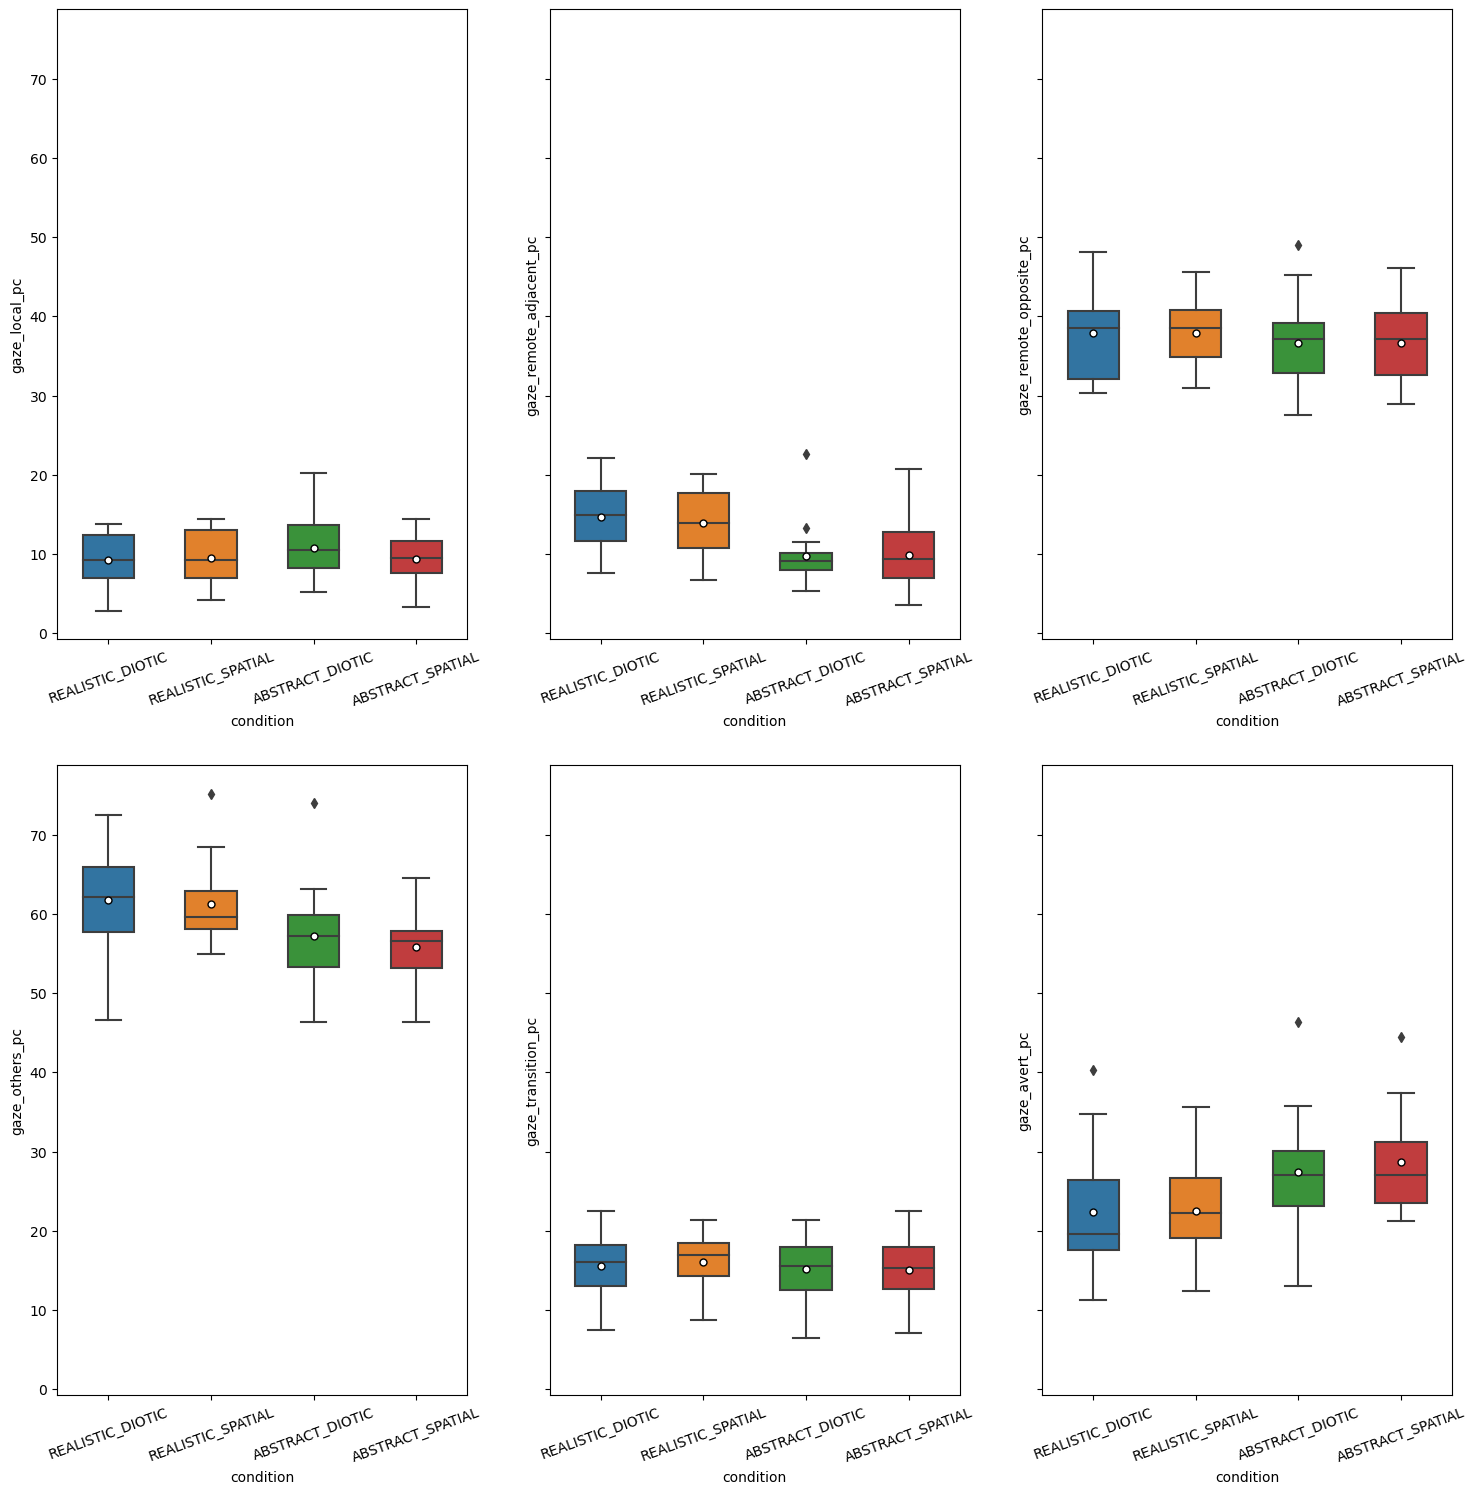

In [46]:
bp = boxplot_all(averaged_trial_df, pc_cols, "pc_boxplots.svg", order=condition_order)

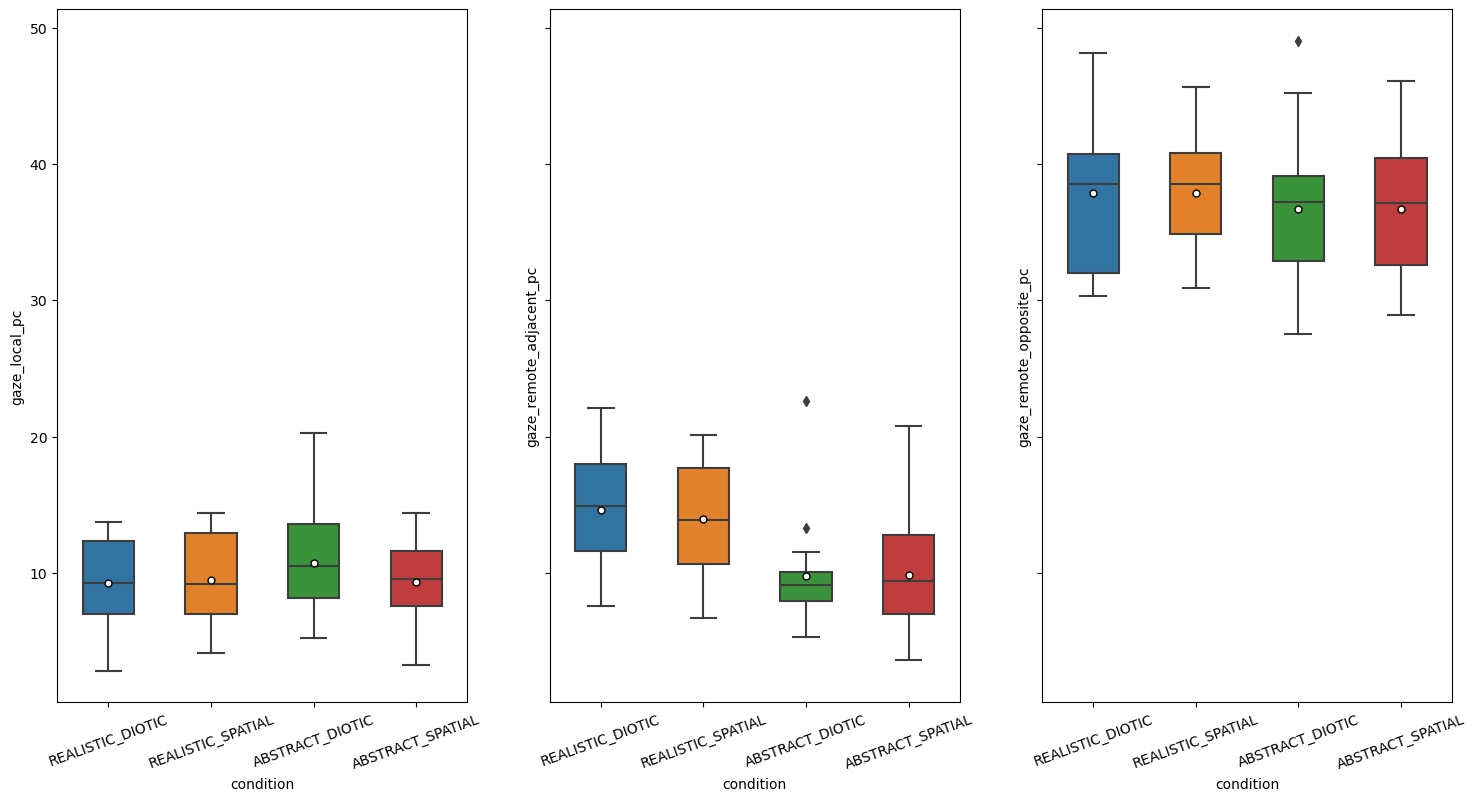

In [16]:
bp = boxplot_all(averaged_trial_df, ['gaze_local_pc', 'gaze_remote_adjacent_pc', 'gaze_remote_opposite_pc'], "pc_boxplots_presentation.svg", order=condition_order)

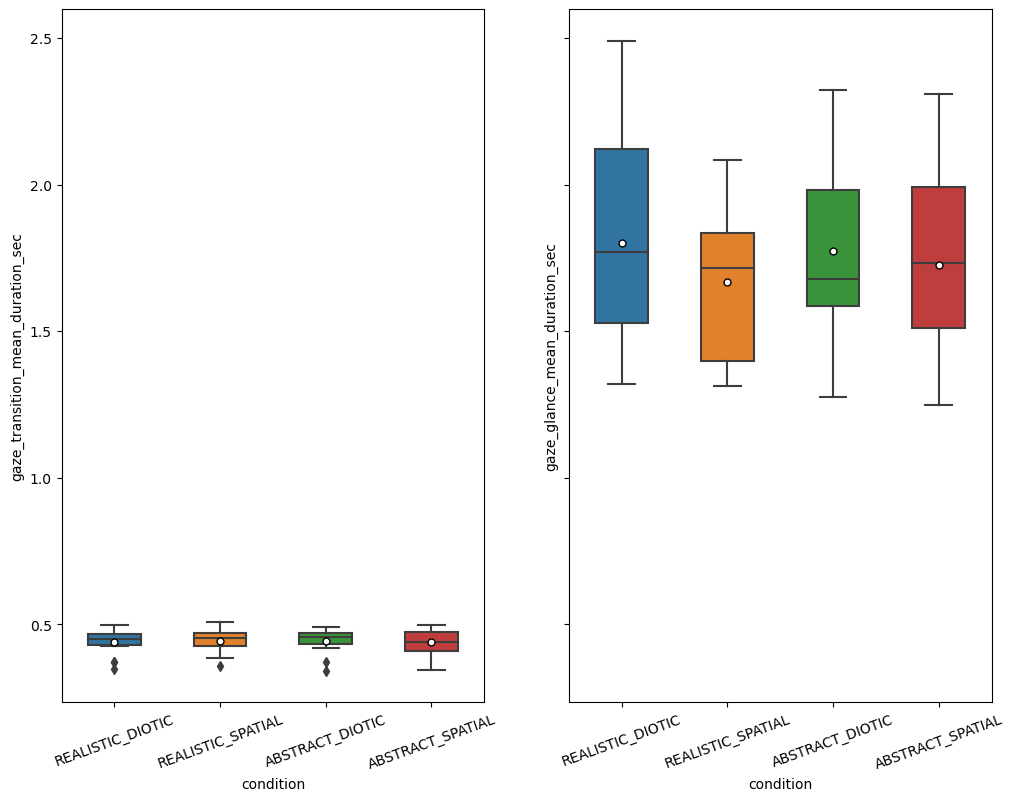

In [17]:
bp = boxplot_all(averaged_trial_df, duration_cols, "duration_boxplots.pdf", ncols=2, order=condition_order)

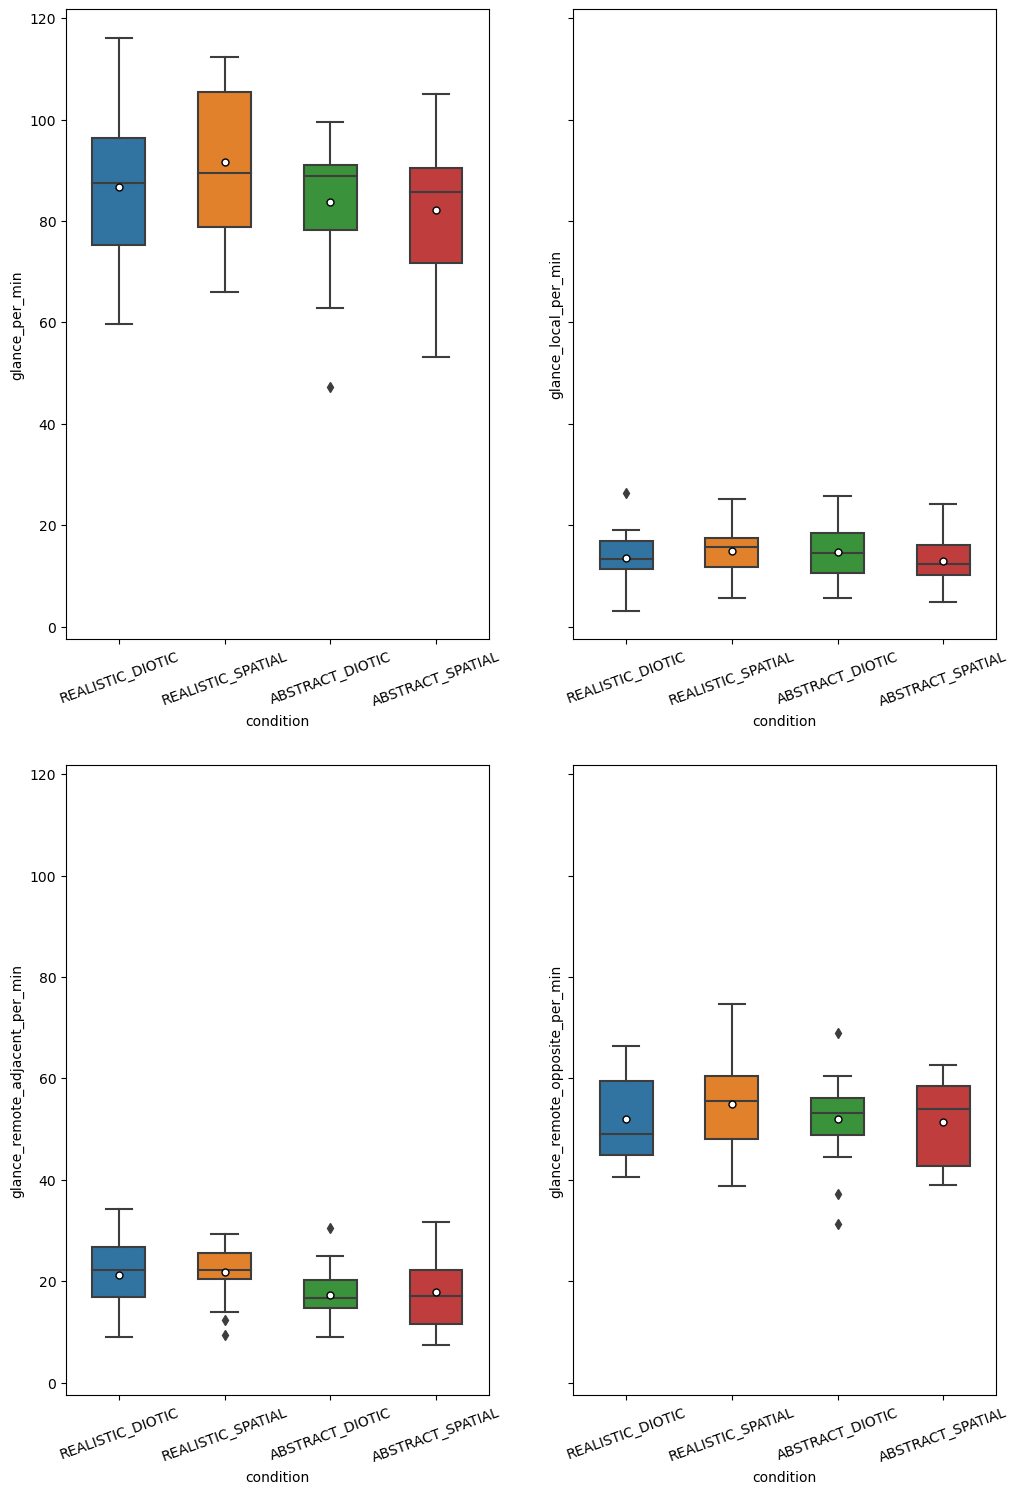

In [18]:
bp = boxplot_all(averaged_trial_df, freq_cols, "freq_boxplots.pdf", ncols=2, order=condition_order)

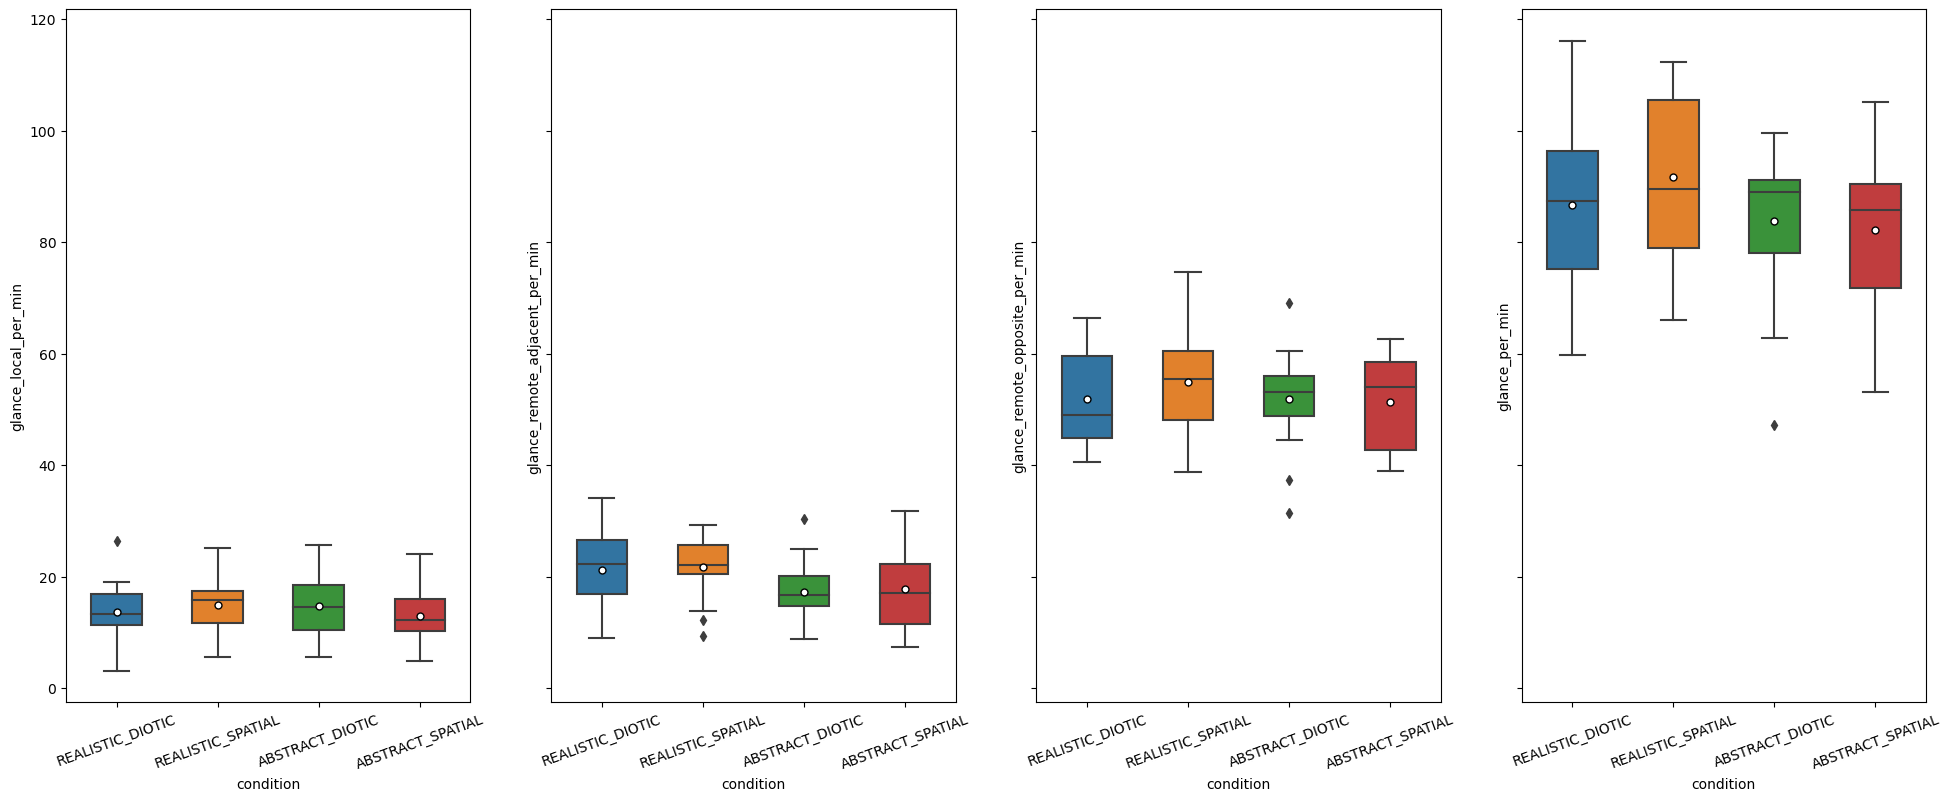

In [19]:
bp = boxplot_all(averaged_trial_df, ['glance_local_per_min','glance_remote_adjacent_per_min','glance_remote_opposite_per_min','glance_per_min']\
                 , "freq_boxplots_presentation.svg", ncols=4, order=condition_order)

# Gaze Classification

Comparing gaze metrics for local and collocated users


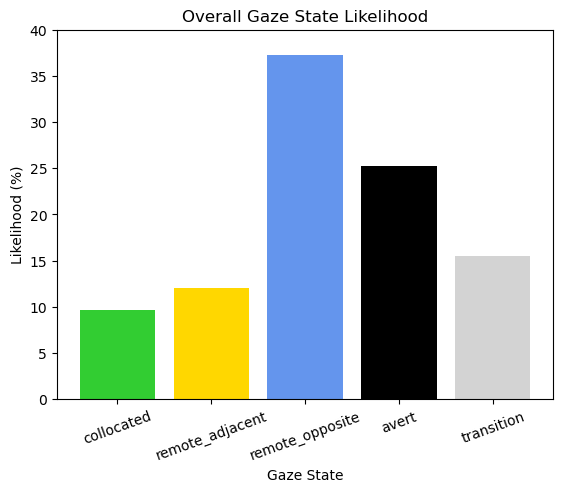

In [56]:
# compare proportion of time spent in each gaze state
columns = ['gaze_local_pc', 'gaze_remote_adjacent_pc', 'gaze_remote_opposite_pc', 'gaze_avert_pc', 'gaze_transition_pc']

bar_colours = ['limegreen', 'gold', 'cornflowerblue', 'black', 'lightgray']

labels = [c.replace('_pc','').replace('gaze_','') for c in columns]
labels[0] = 'collocated'

plt.bar(labels, averaged_group_df[columns].mean(), color=bar_colours)
plt.ylabel('Likelihood (%)')
plt.xlabel('Gaze State')
plt.title('Overall Gaze State Likelihood')
plt.xticks(labels, rotation=20)
plt.ylim((0,40))
plt.show()


In [21]:
# Is difference between remote_adjacent and local significant?

# dependent samples - analyse normality of differences
differences = averaged_group_df['gaze_local_pc'] - averaged_group_df['gaze_remote_adjacent_pc']
stat, p_value = shapiro(differences)

# plt.hist(differences, bins='auto', edgecolor='black', alpha=0.7)
# plt.title('Histogram of Differences Between Paired Samples')
# plt.xlabel('Difference')
# plt.ylabel('Frequency')
# plt.grid(True)
# plt.show()

print(f"Shapiro-Wilk Test Statistic: {stat}")
print(f"P-value: {p_value}")
if p_value > 0.05:
    print("The differences are likely normally distributed (fail to reject the null hypothesis).")
else:
    print("The differences are likely not normally distributed (reject the null hypothesis).")

t_statistic, p_value = ttest_rel(averaged_group_df['gaze_local_pc'], averaged_group_df['gaze_remote_adjacent_pc'])
    
print(f"T-statistic: {t_statistic}")
print(f"P-value: {p_value}")


Shapiro-Wilk Test Statistic: 0.9433547258377075
P-value: 0.39215561747550964
The differences are likely normally distributed (fail to reject the null hypothesis).
T-statistic: -1.7976853127704655
P-value: 0.09238276704893286


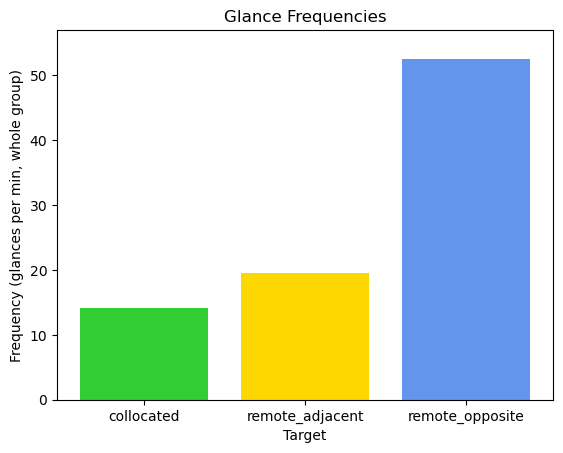

In [57]:
# compare frequency of glances at each target
cols = ['glance_local_per_min', 'glance_remote_adjacent_per_min', 'glance_remote_opposite_per_min']

bar_colours = ['limegreen', 'gold', 'cornflowerblue', 'black', 'lightgray']

labels = [c.replace('_per_min','').replace('glance_','') for c in cols]
labels[0] = 'collocated'

plt.bar(labels, averaged_group_df[cols].mean(), color=bar_colours)
plt.ylabel('Frequency (glances per min, whole group)')
plt.xlabel('Target')
plt.title('Glance Frequencies')
plt.xticks(labels, rotation=0)
plt.ylim((0,57))
plt.show()

In [23]:
# Is difference between remote_adjacent and local significant?

# dependent samples - analyse normality of differences
differences = averaged_group_df['glance_remote_adjacent_per_min'] - averaged_group_df['glance_local_per_min']
stat, p_value = shapiro(differences)

# plt.hist(differences, bins='auto', edgecolor='black', alpha=0.7)
# plt.title('Histogram of Differences Between Paired Samples')
# plt.xlabel('Difference')
# plt.ylabel('Frequency')
# plt.grid(True)
# plt.show()

print(f"Shapiro-Wilk Test Statistic: {stat}")
print(f"P-value: {p_value}")
if p_value > 0.05:
    print("The differences are likely normally distributed (fail to reject the null hypothesis).")
else:
    print("The differences are likely not normally distributed (reject the null hypothesis).")

t_statistic, p_value = ttest_rel(averaged_group_df['glance_remote_adjacent_per_min'], averaged_group_df['glance_local_per_min'])

print(f"T-statistic: {t_statistic}")
print(f"P-value: {p_value}")

Shapiro-Wilk Test Statistic: 0.9865520596504211
P-value: 0.9950947761535645
The differences are likely normally distributed (fail to reject the null hypothesis).
T-statistic: 3.031354967906723
P-value: 0.008417477994228787


# Mutual Gaze Analysis

How do experimental conditions affect mutual gaze?

In [24]:
mutual_numeric_cols = numerical_cols.drop([c for c in numerical_cols if "mutual" not in c])

mutual_pc_cols = [c for c in mutual_numeric_cols if "pc" in c and c != "pc_all"]
mutual_duration_cols = [c for c in mutual_numeric_cols if "duration" in c]
mutual_freq_cols = [c for c in mutual_numeric_cols if "per_min" in c]

mutual_pc_cols

print(mutual_pc_cols)
print(mutual_duration_cols)
print(mutual_freq_cols)



# for col in non_mutual_numeric_cols:
#     RunAnova(col)


['mutual_gaze_local_pc', 'mutual_gaze_remote_opp_pc', 'mutual_gaze_remote_adj_pc']
['mutual_glance_local_mean_duration', 'mutual_glance_remote_opp_mean_duration', 'mutual_glance_remote_adj_mean_duration']
['mutual_glance_local_per_min', 'mutual_glance_remote_opp_per_min', 'mutual_glance_remote_adj_per_min']


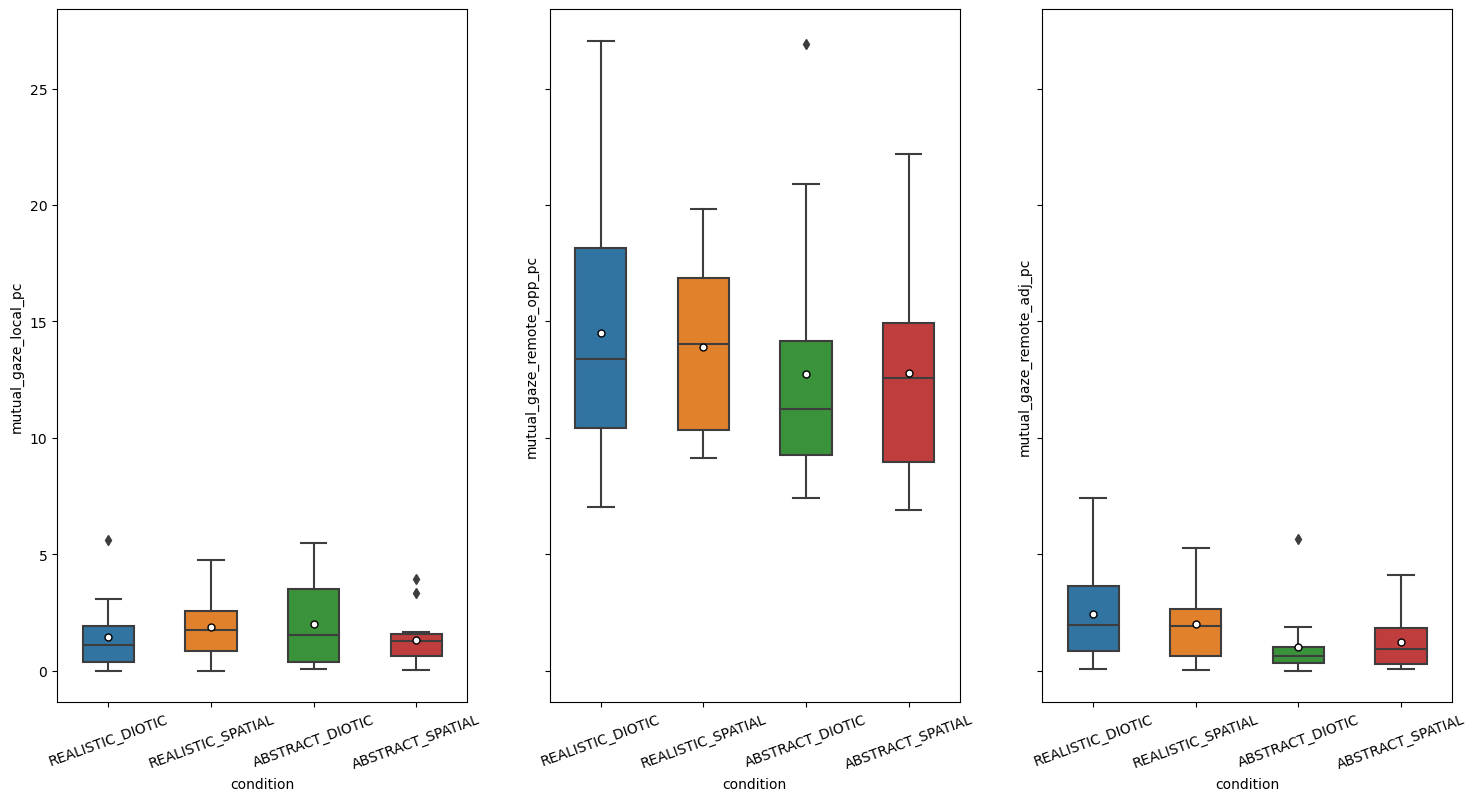

In [25]:
bp = boxplot_all(averaged_trial_df, mutual_pc_cols, "mutual_pc_boxplots.pdf", order=condition_order)

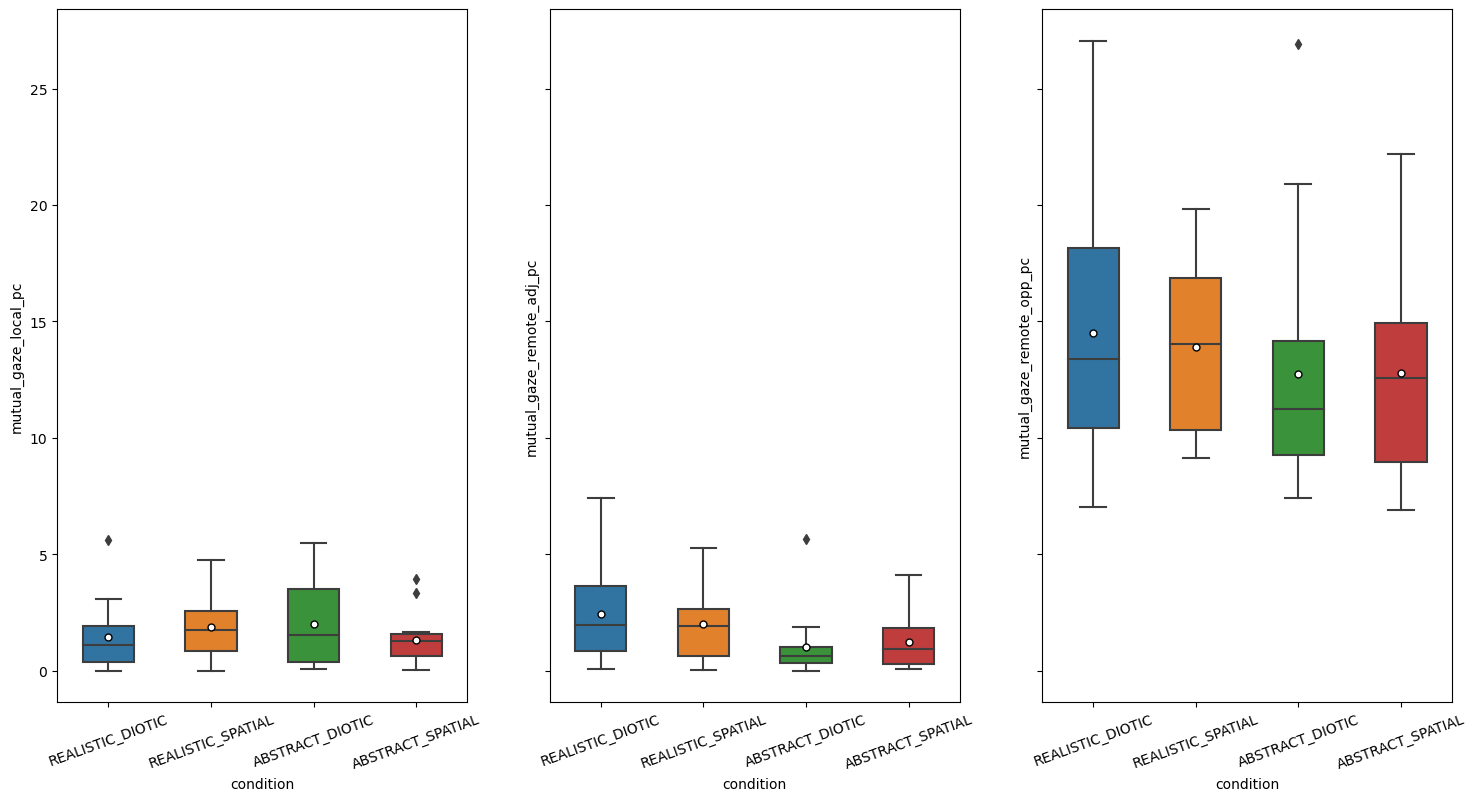

In [26]:
bp = boxplot_all(averaged_trial_df, ['mutual_gaze_local_pc','mutual_gaze_remote_adj_pc','mutual_gaze_remote_opp_pc'], \
                 "mutual_pc_boxplots_presentation.svg", order=condition_order)

In [27]:
# TODO how to deal with negative values for duration here?

# bp = boxplot_all(averaged_trial_df, mutual_duration_cols, "mutual_duration_boxplots.pdf")

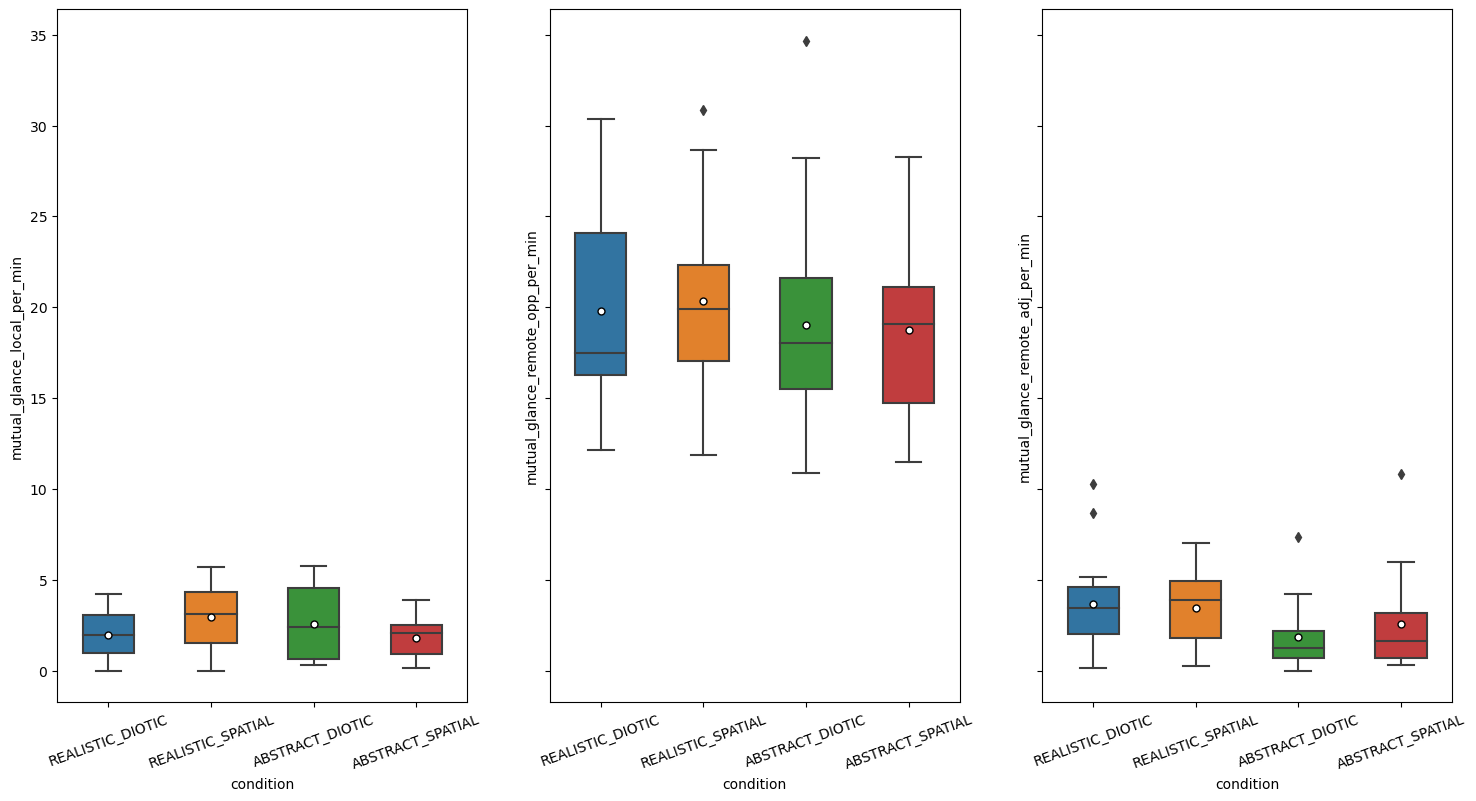

In [28]:
bp = boxplot_all(averaged_trial_df, mutual_freq_cols, "mutual_freq_boxplots.pdf", order=condition_order)

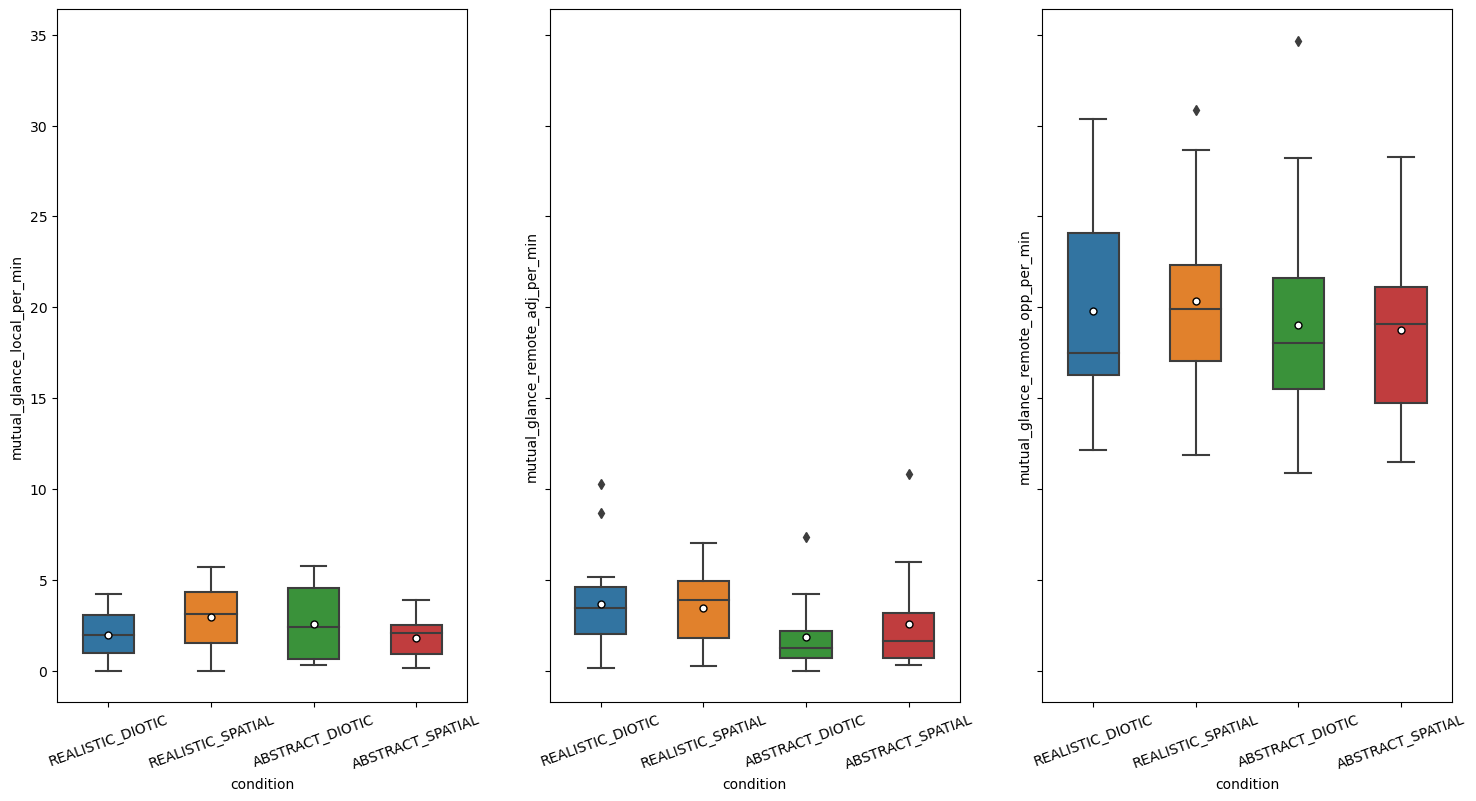

In [30]:
bp = boxplot_all(averaged_trial_df, ['mutual_glance_local_per_min','mutual_glance_remote_adj_per_min','mutual_glance_remote_opp_per_min'],\
                 "mutual_freq_boxplots_presentation.svg", order=condition_order)


In [31]:
for col in mutual_pc_cols:
    RunAnova(col)


Variable: mutual_gaze_local_pc
Not normally distributed
                                   F Value  Num DF  Den DF    Pr > F
audio_condition                   0.396747     1.0    15.0  0.538251
avatar_condition                  0.001174     1.0    15.0  0.973121
audio_condition:avatar_condition  9.930748     1.0    15.0  0.006589


Variable: mutual_gaze_remote_opp_pc
Not normally distributed
                                   F Value  Num DF  Den DF    Pr > F
audio_condition                   0.099377     1.0    15.0  0.756922
avatar_condition                  6.362224     1.0    15.0  0.023447
audio_condition:avatar_condition  0.230484     1.0    15.0  0.638091


Variable: mutual_gaze_remote_adj_pc
Not normally distributed
                                    F Value  Num DF  Den DF    Pr > F
audio_condition                    0.292023     1.0    15.0  0.596860
avatar_condition                  18.251116     1.0    15.0  0.000668
audio_condition:avatar_condition   5.424619     1.0    1

In [32]:
# for col in mutual_duration_cols:
#     RunAnova(col)

In [33]:
for col in mutual_freq_cols:
    RunAnova(col)


Variable: mutual_glance_local_per_min
Not normally distributed
                                    F Value  Num DF  Den DF    Pr > F
audio_condition                    0.277164     1.0    15.0  0.606264
avatar_condition                   1.580405     1.0    15.0  0.227925
audio_condition:avatar_condition  15.459483     1.0    15.0  0.001332


Variable: mutual_glance_remote_opp_per_min
Not normally distributed
                                   F Value  Num DF  Den DF    Pr > F
audio_condition                   0.025583     1.0    15.0  0.875057
avatar_condition                  2.093815     1.0    15.0  0.168471
audio_condition:avatar_condition  0.220678     1.0    15.0  0.645280


Variable: mutual_glance_remote_adj_per_min
Not normally distributed
                                    F Value  Num DF  Den DF    Pr > F
audio_condition                    0.756534     1.0    15.0  0.398121
avatar_condition                  13.219594     1.0    15.0  0.002439
audio_condition:avatar_conditio

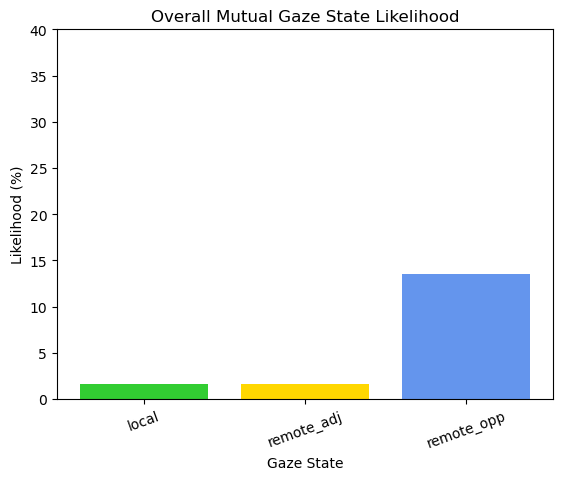

In [55]:
# compare proportion of time spent in each gaze state
cols = ['mutual_gaze_local_pc', 'mutual_gaze_remote_adj_pc', 'mutual_gaze_remote_opp_pc']
bar_colours = ['limegreen', 'gold', 'cornflowerblue', 'black', 'lightgray']

labels = [c.replace('_pc','').replace('mutual_gaze_','') for c in cols]
plt.bar(labels, averaged_group_df[cols].mean(), color=bar_colours)
plt.ylabel('Likelihood (%)')
plt.xlabel('Gaze State')
plt.title('Overall Mutual Gaze State Likelihood')
plt.xticks(labels, rotation=20)
plt.ylim((0,40))
plt.show()

In [35]:
# Is difference between remote_adjacent and local significant?


# dependent samples - analyse normality of differences
differences = averaged_group_df['mutual_gaze_local_pc'] - averaged_group_df['mutual_gaze_remote_adj_pc']
stat, p_value = shapiro(differences)

# plt.hist(differences, bins='auto', edgecolor='black', alpha=0.7)
# plt.title('Histogram of Differences Between Paired Samples')
# plt.xlabel('Difference')
# plt.ylabel('Frequency')
# plt.grid(True)
# plt.show()

print(f"Shapiro-Wilk Test Statistic: {stat}")
print(f"P-value: {p_value}")
if p_value > 0.05:
    print("The differences are likely normally distributed (fail to reject the null hypothesis).")
else:
    print("The differences are likely not normally distributed (reject the null hypothesis).")


t_statistic, p_value = ttest_rel(averaged_group_df['mutual_gaze_local_pc'], averaged_group_df['mutual_gaze_remote_adj_pc'])

print(f"T-statistic: {t_statistic}")
print(f"P-value: {p_value}")

Shapiro-Wilk Test Statistic: 0.9218289852142334
P-value: 0.1805034726858139
The differences are likely normally distributed (fail to reject the null hypothesis).
T-statistic: -0.04622440624509758
P-value: 0.9637411891168444


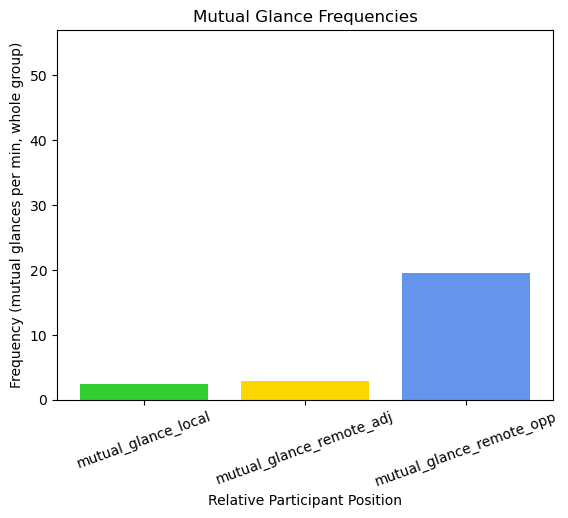

In [58]:
# compare frequency of glances at each target
cols = ['mutual_glance_local_per_min', 'mutual_glance_remote_adj_per_min', 'mutual_glance_remote_opp_per_min']

labels = [c.replace('_per_min','').replace('mutual_gaze_','') for c in cols]
plt.bar(labels, averaged_group_df[cols].mean(), color=bar_colours)
plt.ylabel('Frequency (mutual glances per min, whole group)')
plt.xlabel('Relative Participant Position')
plt.title('Mutual Glance Frequencies')
plt.xticks(labels, rotation=20)
plt.ylim((0,57))
plt.show()

In [40]:
# Is difference between remote_adjacent and local significant?


# dependent samples - analyse normality of differences
differences = averaged_group_df['mutual_glance_local_per_min'] - averaged_group_df['mutual_glance_remote_adj_per_min']
stat, p_value = shapiro(differences)

# plt.hist(differences, bins='auto', edgecolor='black', alpha=0.7)
# plt.title('Histogram of Differences Between Paired Samples')
# plt.xlabel('Difference')
# plt.ylabel('Frequency')
# plt.grid(True)
# plt.show()

print(f"Shapiro-Wilk Test Statistic: {stat}")
print(f"P-value: {p_value}")
if p_value > 0.05:
    print("The differences are likely normally distributed (fail to reject the null hypothesis).")
else:
    print("The differences are likely not normally distributed (reject the null hypothesis).")


t_statistic, p_value = ttest_rel(averaged_group_df['mutual_glance_local_per_min'], averaged_group_df['mutual_glance_remote_adj_per_min'])

print(f"T-statistic: {t_statistic}")
print(f"P-value: {p_value}")


Shapiro-Wilk Test Statistic: 0.9013059735298157
P-value: 0.08433572947978973
The differences are likely normally distributed (fail to reject the null hypothesis).
T-statistic: -0.771945497736119
P-value: 0.4521378965131313
